In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

#Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras import models, layers, Model
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print(os.listdir("/content/drive/MyDrive/2022-2학기/딥러닝/jigsaw classfication"))

['Relu_256_+sampling+regession.ipynb', 'test.csv', 'train.csv', '?폴더', 'ELU.ipynb', 'classification practice.ipynb', 'Relu-1024.ipynb', 'Relu-256 수정할거.ipynb', 'Relu-512.ipynb', 'Relu-256 +sampling.ipynb', 'Relu-256 +sampling+classficiation.ipynb', 'Relu-256 +sampling+layer 제거.ipynb', 'Relu-256 +sampling+학습률 증가.ipynb']


#1. Load Data

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/2022-2학기/딥러닝/jigsaw classfication/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/2022-2학기/딥러닝/jigsaw classfication/test.csv')
print(train_data.shape)
print(test_data.shape)

(1804874, 45)
(97320, 2)


In [ ]:
train_data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


#2. Set index & target label


In [ ]:
train_df = train_data[['id','comment_text','target']]

In [ ]:
df_1=train_df[(train_df['target'] >=0.5)&(train_df['target']<1)]
df_1

,id,comment_text,target
4,59856,haha you guys are a bunch of losers.,0.893617
5,59859,ur a sh*tty comment.,0.666667
13,239583,It's ridiculous that these guys are being call...,0.600000
14,239584,This story gets more ridiculous by the hour! A...,0.500000
19,239592,"Angry trolls, misogynists and Racists"", oh my....",0.500000
...,...,...,...
1804825,6333841,Who is the jerk in the last row between the C ...,0.833333
1804838,6333871,Nobody really cares that she supports the scie...,0.700000
1804856,6333923,Believing in God or not believing in God are p...,0.500000
1804857,6333927,"I take your point, but I think you're shooting...",0.700000


In [ ]:
df_2=train_df[(train_df['target'] <0.5)&(train_df['target']>0)]
df_2

,id,comment_text,target
6,59861,hahahahahahahahhha suck it.,0.457627
11,239579,This is a great story. Man. I wonder if the pe...,0.440000
39,239625,Pity the menu lost so much vegan food! The Mas...,0.166667
44,239632,YET ANOTHER BARACK OBAMA LIBERAL MEDIA CONSPIR...,0.166667
46,239635,I'm crazy about that illustration! I never wou...,0.200000
...,...,...,...
1804858,6333928,My thought exactly. The only people he hasn't...,0.200000
1804863,6333950,"Nah, I am too boring to parody. This guy Camp...",0.200000
1804865,6333955,Payette's point of view is legitimate and I th...,0.166667
1804866,6333957,There's no whine like Alberta whine!,0.300000


In [ ]:
df_3=df_2.sample(n=139928)
df_3

,id,comment_text,target
1634171,6123856,C1 \nvery funny comment \nactually ...somewhat...,0.166667
1067019,5420658,So you're suggesting that people's rights and ...,0.200000
232366,527113,my family and I are voting for Trump .. the Re...,0.200000
364650,689615,"Right, but Burke has no taste, no style and is...",0.400000
530688,892553,Kind of lame to rate your own posting. whazzup...,0.166667
...,...,...,...
1229292,5617062,"""Fat Cats"" like Nancy Pelosi and Chuck Shumer?...",0.200000
1327579,5737882,"The point, which you missed completely, is tha...",0.166667
756818,5046875,since the Glob appears to be going all CBC on ...,0.300000
197743,483308,"Oh, relax, Chugiak!\n\nHere, have some Skittle...",0.200000


In [ ]:
df_4=pd.concat([df_1,df_3],axis=0)
df_4

,id,comment_text,target
4,59856,haha you guys are a bunch of losers.,0.893617
5,59859,ur a sh*tty comment.,0.666667
13,239583,It's ridiculous that these guys are being call...,0.600000
14,239584,This story gets more ridiculous by the hour! A...,0.500000
19,239592,"Angry trolls, misogynists and Racists"", oh my....",0.500000
...,...,...,...
1229292,5617062,"""Fat Cats"" like Nancy Pelosi and Chuck Shumer?...",0.200000
1327579,5737882,"The point, which you missed completely, is tha...",0.166667
756818,5046875,since the Glob appears to be going all CBC on ...,0.300000
197743,483308,"Oh, relax, Chugiak!\n\nHere, have some Skittle...",0.200000


In [ ]:
df_5 = df_4.sort_index(ascending=True)
df_5

,id,comment_text,target
4,59856,haha you guys are a bunch of losers.,0.893617
5,59859,ur a sh*tty comment.,0.666667
6,59861,hahahahahahahahhha suck it.,0.457627
11,239579,This is a great story. Man. I wonder if the pe...,0.440000
13,239583,It's ridiculous that these guys are being call...,0.600000
...,...,...,...
1804849,6333900,"A Democrat accused of sexual harassment, go fi...",0.400000
1804856,6333923,Believing in God or not believing in God are p...,0.500000
1804857,6333927,"I take your point, but I think you're shooting...",0.700000
1804866,6333957,There's no whine like Alberta whine!,0.300000


In [ ]:
train_df=df_5

In [ ]:
test_df = test_data.copy()

# set index
train_df.set_index('id', inplace=True)
test_df.set_index('id', inplace=True)

# y_label
train_y_label = train_df['target'].values # Label 1 >= 0.5 / Label 0 < 0.5
train_df.drop(['target'], axis=1, inplace=True)

In [ ]:
train_y_label

array([0.89361702, 0.66666667, 0.45762712, ..., 0.7       , 0.3       ,
       0.62121212])

#3. View text data


In [ ]:
train_data['comment_text'].head(20)

0     This is so cool. It's like, 'would you want yo...
1     Thank you!! This would make my life a lot less...
2     This is such an urgent design problem; kudos t...
3     Is this something I'll be able to install on m...
4                  haha you guys are a bunch of losers.
5                                  ur a sh*tty comment.
6                           hahahahahahahahhha suck it.
7                                   FFFFUUUUUUUUUUUUUUU
8     The ranchers seem motivated by mostly by greed...
9     It was a great show. Not a combo I'd of expect...
10                              Wow, that sounds great.
11    This is a great story. Man. I wonder if the pe...
12       This seems like a step in the right direction.
13    It's ridiculous that these guys are being call...
14    This story gets more ridiculous by the hour! A...
15    I agree; I don't want to grant them the legiti...
16    Interesting. I'll be curious to see how this w...
17                      Awesome! I love Civil Co

#4. Remove Punctuation & Stopword

In [ ]:
## Clean Punctuation & Stopwords
class clean_text:
	def __init__(self, text):
		self.text = text

	# Remove Punctuation
	def rm_punct(text):
		punct = set([p for p in "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'])
		text = [t for t in text if t not in punct]

		return "".join(text)

	# Remove Stopwords
	def rm_stopwords(text):
		word_tokens = word_tokenize(text)
		result = [w for w in word_tokens if w not in stop_words]

		return " ".join(result)

In [ ]:
# remove punctuation
train_df['comment_text'] = train_df['comment_text'].apply(lambda x: clean_text.rm_punct(x))
test_df['comment_text'] = test_df['comment_text'].apply(lambda x: clean_text.rm_punct(x))

# remove stopwords
X_train = train_df['comment_text'].apply(lambda x: clean_text.rm_stopwords(x))
X_test = test_df['comment_text'].apply(lambda x: clean_text.rm_stopwords(x))

#5. Tokenize

In [ ]:
## tokenize
max_words = 100000
tokenizer = text.Tokenizer(num_words=max_words) # Tokenizer 객체생성
tokenizer.fit_on_texts(X_train)	# 토큰 별 word index 생성

# texts_to_sequences
sequences_text_train = tokenizer.texts_to_sequences(X_train)
sequences_text_test = tokenizer.texts_to_sequences(X_test)

print(sequences_text_train[:5])

[[4268, 430, 433, 818], [5339, 33749, 154], [76381, 1250], [19, 143, 290, 69, 1, 351, 110, 10317, 647, 3122, 96, 582], [34, 261, 430, 230, 2030, 1879, 1379, 880, 366, 190, 662]]


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# add padding
max_len = max(len(l) for l in sequences_text_train)
pad_train = pad_sequences(sequences_text_train, maxlen=max_len)
pad_test = pad_sequences(sequences_text_test, maxlen=max_len)

print(pad_train[:5])

[[    0     0     0 ...   430   433   818]
 [    0     0     0 ...  5339 33749   154]
 [    0     0     0 ...     0 76381  1250]
 [    0     0     0 ...  3122    96   582]
 [    0     0     0 ...   366   190   662]]


#6. Embedding + LSTM model

In [ ]:
def Embedding_CuDNNLSTM_model(max_words, max_len):
	sequence_input = layers.Input(shape=(None, ))
	x = layers.Embedding(max_words, 128, input_length=max_len)(sequence_input)
	x = layers.SpatialDropout1D(0.4)(x)
	x = layers.Bidirectional(layers.CuDNNLSTM(64, return_sequences=True))(x)
	x = layers.Bidirectional(layers.CuDNNLSTM(64, return_sequences=True))(x)

	avg_pool1d = layers.GlobalAveragePooling1D()(x)
	max_pool1d = layers.GlobalMaxPool1D()(x)

	x = layers.concatenate([avg_pool1d, max_pool1d])
	x = layers.Dense(32, activation='relu')(x)
	x = layers.BatchNormalization()(x)
	output = layers.Dense(1)(x)

	model = models.Model(sequence_input, output)

	return model
## embedding_lstm models
model = Embedding_CuDNNLSTM_model(max_words, max_len)

# model compile
adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,
			 loss='mse')
#acc랑 auc 선택하는듯
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    12800000    ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, None, 128)   0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 128)    99328       ['spatial_dropout1d[0][0]']  

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# keras.callbacks
callbacks_list = [
		ReduceLROnPlateau(
			monitor='val_loss', patience=2, factor=0.1, mode='max'),	# val_loss가 patience동안 향상되지 않으면 학습률을 0.1만큼 감소 (new_lr = lr * factor)
		EarlyStopping(
			patience=5, monitor='val_loss', mode='max', restore_best_weights=True),
		ModelCheckpoint(
			filepath='/content/drive/MyDrive/jigsaw classfication/best_embedding_lstm_model.h5', monitor='val_loss', mode='max', save_best_only=True)
]

# model fit & save
model_path = '/content/drive/MyDrive/jigsaw classfication/best_embedding_lstm_model.h5'
if os.path.exists(model_path):
	model.load_weights(model_path)
else:
	history = model.fit(pad_train, train_y_label,
						epochs=7, batch_size=256,
						callbacks=callbacks_list,
						validation_split=0.3, verbose=1)

Epoch 1/7
766/766 [==============================] - 87s 104ms/step - loss: 0.1006 - val_loss: 0.0333 - lr: 1.0000e-04
Epoch 2/7
766/766 [==============================] - 79s 103ms/step - loss: 0.0306 - val_loss: 0.0268 - lr: 1.0000e-04
Epoch 3/7
766/766 [==============================] - 80s 104ms/step - loss: 0.0257 - val_loss: 0.0252 - lr: 1.0000e-04
Epoch 4/7
766/766 [==============================] - 80s 105ms/step - loss: 0.0232 - val_loss: 0.0267 - lr: 1.0000e-05
Epoch 5/7
766/766 [==============================] - 80s 105ms/step - loss: 0.0230 - val_loss: 0.0250 - lr: 1.0000e-05
Epoch 6/7
766/766 [==============================] - 84s 109ms/step - loss: 0.0227 - val_loss: 0.0251 - lr: 1.0000e-06


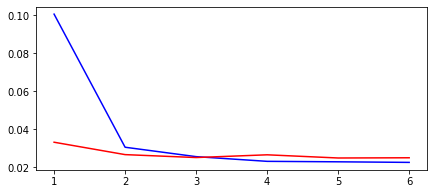

In [ ]:
# plot score by epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(7,3))
plt.plot(epochs, loss, 'b', label='loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')


In [ ]:
## predict test_set
test_pred = model.predict(pad_test)

3042/3042 [==============================] - 60s 20ms/step
